Importar Librerías

In [3]:
import pandas as pd
import numpy as np
import h5py
import os
import torch
#import helper
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Definir variables globales

In [9]:
ancho = 160
alto = 129
canales = 3
pixeles = ancho*alto*canales
cantidadClases = 5
clases = ['Banano', 'Granada', 'Kiwi', 'Mango', 'Pitaya']

Definir Función Auxiliar

In [10]:
def view_classify(img, ps):
  ps = ps.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(16,13), ncols=2)
  ax1.imshow(img.numpy().transpose((1, 2, 0)))
  ax1.axis('off')
  ax2.barh(np.arange(cantidadClases), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(cantidadClases))
  ax2.set_yticklabels(clases, size='medium');
  ax2.set_title('Proabilidad de las Clases')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

Importar dataset

In [11]:
#Se transforma a la mitad del tamaño por restricciones de memoria
transform = transforms.Compose([transforms.Resize((ancho, 129)),transforms.ToTensor(),])
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Train')
trainset = ImageFolder(root=dataset_path, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

La función de activación será relu para las capas ocultas y doftmax para la capa final: https://www.mdpi.com/2079-9292/12/14/3132

In [12]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(pixeles, 20640)
    self.fc2 = nn.Linear(20640, 6880)
    self.fc3 = nn.Linear(6880, 2293)
    self.fc4 = nn.Linear(2293, 764)
    self.fc5 = nn.Linear(764, 254)
    self.fc6 = nn.Linear(254, 84)
    self.fc7 = nn.Linear(84, cantidadClases)
      
  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    x = F.relu(x)
    x = self.fc7(x)
    x = F.softmax(x, dim=1)
    
    return x

model = Network()
model

Network(
  (fc1): Linear(in_features=61920, out_features=20640, bias=True)
  (fc2): Linear(in_features=20640, out_features=6880, bias=True)
  (fc3): Linear(in_features=6880, out_features=2293, bias=True)
  (fc4): Linear(in_features=2293, out_features=764, bias=True)
  (fc5): Linear(in_features=764, out_features=254, bias=True)
  (fc6): Linear(in_features=254, out_features=84, bias=True)
  (fc7): Linear(in_features=84, out_features=5, bias=True)
)

In [13]:
model.fc1.bias.data.fill_(0)
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0004, -0.0073, -0.0144,  ...,  0.0196,  0.0003, -0.0076],
        [ 0.0020,  0.0026,  0.0054,  ...,  0.0037, -0.0013,  0.0084],
        [ 0.0015, -0.0020, -0.0073,  ...,  0.0137,  0.0099, -0.0098],
        ...,
        [-0.0056, -0.0002,  0.0129,  ..., -0.0084,  0.0116,  0.0148],
        [ 0.0078, -0.0079,  0.0078,  ..., -0.0060,  0.0013,  0.0051],
        [-0.0139, -0.0043,  0.0075,  ..., -0.0062, -0.0196,  0.0016]])

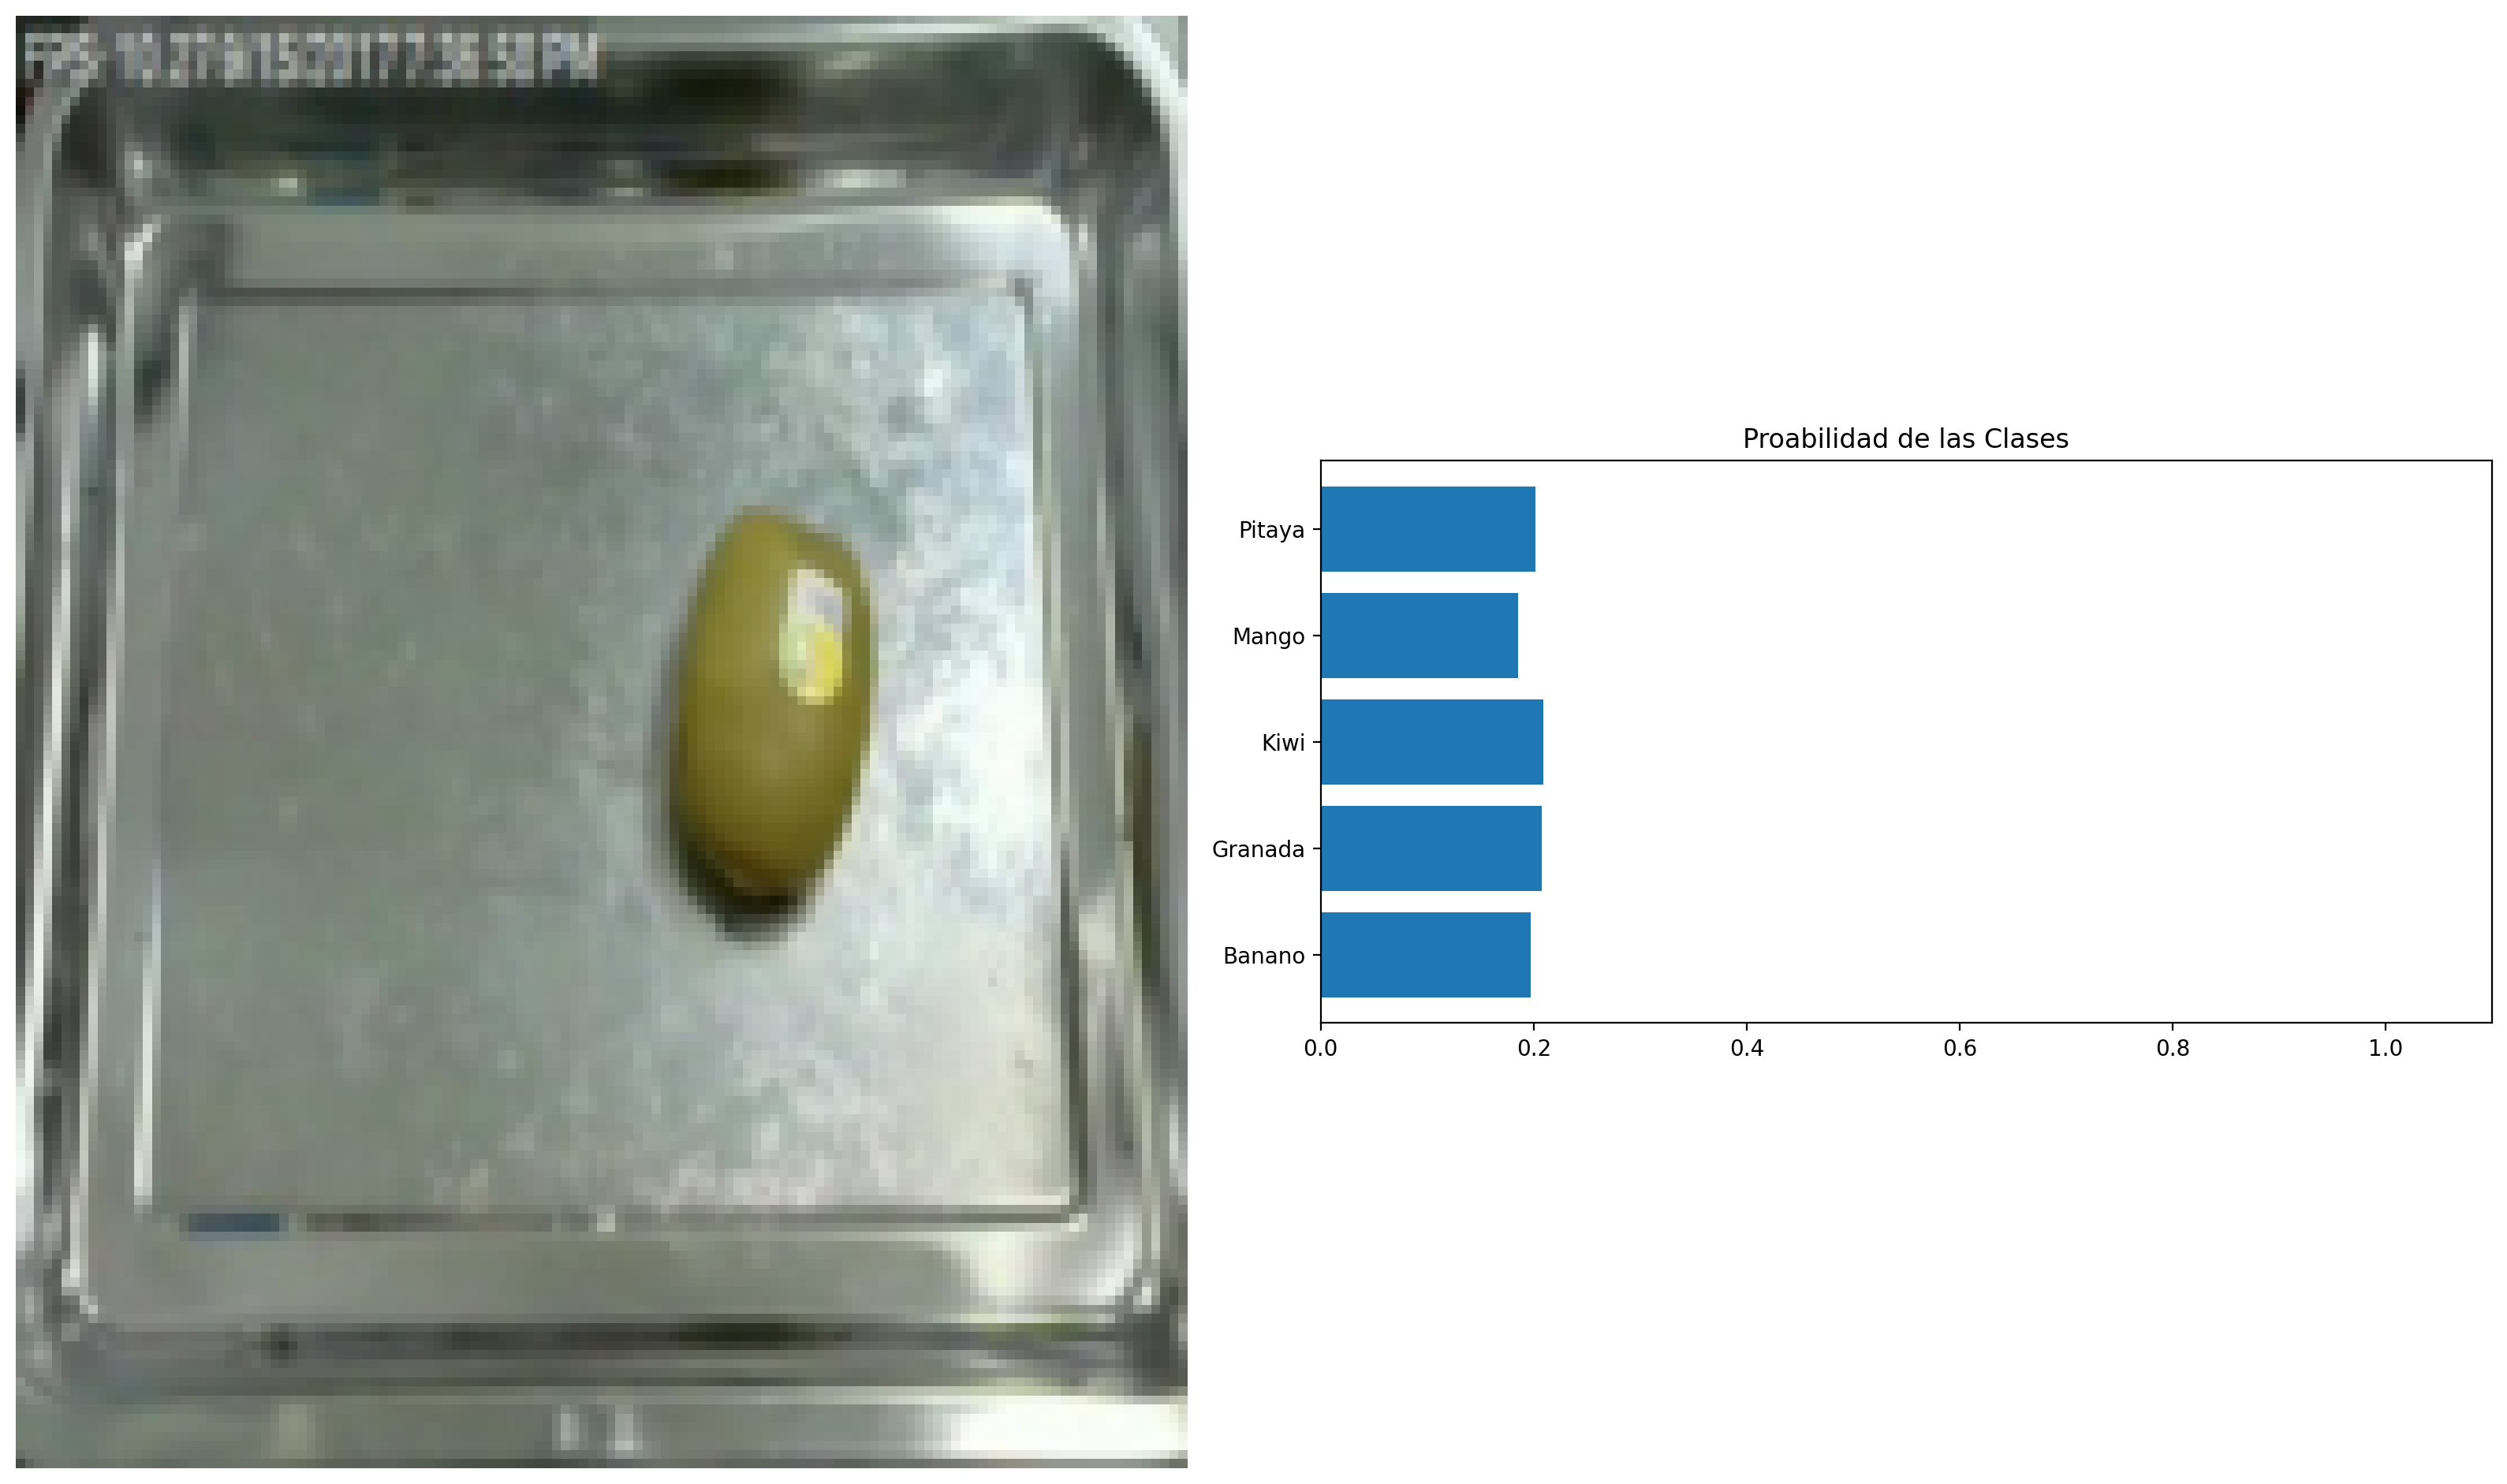

In [14]:
# Grab some data 
dataiter = iter(trainloader)  # Asegúrate de usar el `train_loader` correcto para tu dataset
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

# No es necesario redimensionar las imágenes, ya que se mantienen en su formato original
# (batch_size, color_channels, height, width) ya es (batch_size, 3, 320, 258)
# Forward pass a través de la red
img_idx = 0  # Puedes cambiar el índice para ver otras imágenes
ps = model.forward(images[img_idx,:].unsqueeze(0))  # Asegúrate de agregar un batch dimension con unsqueeze(0)

# Obtener la imagen y mostrarla con las probabilidades
img = images[img_idx]
view_classify(img.view(canales, ancho, alto), ps)

In [16]:
input_size = pixeles
hidden_sizes = [20640, 6880, 2293, 764, 254, 84]
output_size = cantidadClases

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[5], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=61920, out_features=20640, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20640, out_features=6880, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6880, out_features=2293, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2293, out_features=764, bias=True)
  (7): ReLU()
  (8): Linear(in_features=764, out_features=254, bias=True)
  (9): ReLU()
  (10): Linear(in_features=254, out_features=84, bias=True)
  (11): ReLU()
  (12): Linear(in_features=84, out_features=5, bias=True)
  (13): Softmax(dim=1)
)
